In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score, roc_curve, auc,confusion_matrix
from sklearn.metrics import RocCurveDisplay


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/sgl-arbres-urbains-wgs84.csv

Mounted at /content/drive
ls: cannot access '/content/drive/MyDrive/sgl-arbres-urbains-wgs84.csv': No such file or directory


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/colab/PROJECT/sgl-arbres-urbains-wgs84.csv')
dataset= df.iloc[:,:17]
#rENAME COLUMNS
dataset.rename(columns={"ID_ARBRE":"TREE_ID", "commune":"municipality", "quartier":"district",
                        "cote_voirie":"road_side","matricule_arbre":"tree_number",
                        "genre_arbre":"tree_genus", "espece_arbre":"tree_species", 
                        "controle":"control","type_sol":"soil_type", "surf_permeable":"permeable_surf",
                  "date_plantation":"planting_date","classe_age":"age_class", "hauteur":"height", 
                  "classe_hauteur":"height_class", "diametre":"diameter"},inplace=True)
#Target variable
label = df["classification_diagnostic"]

#Join the target variable with the dataset to have a single dataframe
dataset["classification_diagnostic"]=label


In [ ]:
dataset.head(5)

,TREE_ID,municipality,district,site,road_side,tree_number,tree_genus,tree_species,control,situation,soil_type,permeable_surf,planting_date,age_class,height,height_class,diameter,classification_diagnostic
0,78551-Arbres-001,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,7,Betula,Alba,NaN,Groupe,P,5.0,2000,A,1000,H2,63.661977,C2
1,78551-Arbres-002,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,8,Betula,Alba,NaN,Groupe,P,5.0,2000,A,1000,H2,60.478878,C2
2,78551-Arbres-003,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,9,Betula,Alba,NaN,Groupe,P,5.0,2000,A,1000,H2,54.112681,C2
3,78551-Arbres-004,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,1,Carpinus,Betulus - L. - Fastigiata,NaN,Bosquet,G,100.0,1980,A,1600,H4,63.661977,C2
4,78551-Arbres-005,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,2,Carpinus,Betulus - L. - Fastigiata,NaN,Bosquet,G,100.0,1980,A,1600,H4,190.985932,C2


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TREE_ID                    709 non-null    object 
 1   municipality               709 non-null    object 
 2   district                   709 non-null    object 
 3   site                       709 non-null    object 
 4   road_side                  545 non-null    object 
 5   tree_number                709 non-null    int64  
 6   tree_genus                 709 non-null    object 
 7   tree_species               701 non-null    object 
 8   control                    11 non-null     float64
 9   situation                  708 non-null    object 
 10  soil_type                  709 non-null    object 
 11  permeable_surf             709 non-null    float64
 12  planting_date              709 non-null    int64  
 13  age_class                  709 non-null    object 

In [ ]:
dataset.describe()

,tree_number,control,permeable_surf,planting_date,height,diameter
count,709.000000,11.0,709.000000,709.000000,709.000000,709.000000
mean,21.843441,1.0,7.198872,1996.530324,692.524683,45.520559
std,17.787176,0.0,21.032527,69.052103,333.023261,27.141451
min,1.000000,1.0,0.000000,200.000000,250.000000,12.732395
25%,7.000000,1.0,1.000000,1980.000000,500.000000,28.647890
50%,17.000000,1.0,1.500000,2000.000000,600.000000,38.197186
75%,33.000000,1.0,4.000000,2010.000000,800.000000,57.295780
max,74.000000,1.0,100.000000,2019.000000,2500.000000,222.816920


In [ ]:
cor_matrix = dataset.corr()
cor_matrix

,tree_number,control,permeable_surf,planting_date,height,diameter
tree_number,1.000000,NaN,-0.217633,-0.007850,-0.164903,-0.109965
control,NaN,NaN,NaN,NaN,NaN,NaN
permeable_surf,-0.217633,NaN,1.000000,-0.071507,0.604309,0.408231
planting_date,-0.007850,NaN,-0.071507,1.000000,-0.090306,-0.155416
height,-0.164903,NaN,0.604309,-0.090306,1.000000,0.759239
diameter,-0.109965,NaN,0.408231,-0.155416,0.759239,1.000000


Handling the missing variables by imputing it with the highest occurences

In [ ]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
dataset=imp_mode.fit_transform(dataset)
column_names=['TREE_ID','municipality','district','site','road_side',
              'tree_number','tree_genus','tree_species','control','situation',
              'soil_type','permeable_surf','planting_date','age_class','height',
              'height_class',	'diameter','classification_diagnostic']
df_imp=pd.DataFrame(dataset,columns=column_names)
df_imp['classification_diagnostic'].value_counts()

C2    408
C1    237
C3     43
C4     11
C5     10
Name: classification_diagnostic, dtype: int64

In [ ]:
#Features X
X=df_imp.iloc[:,:17]
#Labels (Target variable)
y=df_imp["classification_diagnostic"]

Preprocessing 

In [ ]:
#cartegorical data 
enc = OneHotEncoder(handle_unknown="ignore",sparse=False)
X_t=enc.fit_transform(X)

#label data
label= preprocessing.LabelEncoder()
y_t=label.fit_transform(y)


df1 = pd.DataFrame(X_t)
df2 = pd.DataFrame(y_t)

#SCALING THE FEATURE
scaler = preprocessing.StandardScaler().fit(X_t)
X_scaled = scaler.transform(X_t)

In [ ]:
#print(scaler.mean_)
#print(scaler.scale_)
#print(X_scaled)

# DATA SPLIT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.2, random_state=0)
print(y_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(567,)
(567,)
(142, 989)
(142,)


# LOGISTIC REGRESSION

In [ ]:
#using the split training set
# define model
model = LogisticRegression()

# define the ovr strategy
ovr1 = OneVsRestClassifier(model)
# fit model
ovr1.fit(X_train, y_train)
# make predictions
yhat = ovr1.predict(X_test)
print(yhat)
#Acuracy
print("model score: %.3f" % ovr1.score(X_test, y_test))

[1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 1 1 1 0 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1
 0 1 1 0 1 0 1 4 1 0 0 1 1 0 1 0 0 2 1 1 2 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0
 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 2 0 1 0 1 1 1 0 0 0 1 1 1 1 1]
model score: 0.775


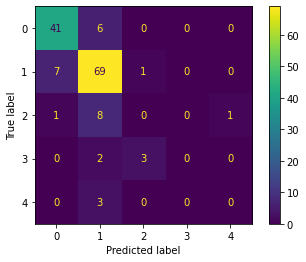

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
predictions = ovr1.predict(X_test)
cm = confusion_matrix(y_test, yhat, labels=ovr1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ovr1.classes_)
disp.plot()
plt.show()

Because of the imbalanced label,we consider other metrics, we  Compute precision, recall, F-measure and ROC below.

In [ ]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, yhat)

0.3536888643271622

PRECISION,RECALL AND F1-SCORE

Precision

In [ ]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_test, yhat, average=None,zero_division=1)

array([0.83673469, 0.78409091, 0.        , 1.        , 0.        ])

Recall

In [ ]:
recall_score(y_test, yhat, average=None, zero_division=1)

array([0.87234043, 0.8961039 , 0.        , 0.        , 0.        ])

F1 score

In [ ]:
print(f1_score(y_test, yhat, average=None))

[0.85416667 0.83636364 0.         0.         0.        ]


In order to avoid variance problem: a situation where our accuracy obtained on one test is very different to accuracy obtained on another test set using the same algorithm. we consider  consider the method of cross validation,this method ensure that every set is atleast used once for training and once for testing set,the final result is the average of results obtained using all folds,this way we get rid of the variance using the standard deviation of the results obtained from each fold.


We also used the Grid search parameter selection since random selection of Hyperparameter can be exhaustive, we used this method to automatically select the best parameter for our model.Though grid search can be very slow owing to the potential huge number of combinations to test.

In [ ]:
#using the grid searchCV
#define models and parameters of lOGISTIC REGRESSION
solvers = ['newton-cg', 'lbfgs', 'liblinear'] #it allow us to see useful differences in performance or convergence with different solvers (solver).
penalty = ['l2']  #Regularization (penalty) 
c_values = [100, 10, 1.0, 0.1, 0.01] #The C parameter controls the penality strength
model = LogisticRegression(multi_class='ovr')
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_scaled, y_t)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.766311 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.765842 (0.034798) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.766311 (0.035008) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.720268 (0.043202) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.764903 (0.036228) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.764903 (0.036228) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.721677 (0.042884) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.763964 (0.034842) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.763964 (0.034842) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.723085 (0.043895) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.765372 (0.036442) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.765372 (0.036442) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.725433 (0.045287) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.763970 (0.038272) with: {

**LINEARSVM**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.2, random_state=0)
# Run classifier
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True))
clf=classifier.fit(X_train, y_train)
print("model score: %.3f" % classifier.score(X_test, y_test))
yhat=classifier.predict(X_test)
print(yhat)
y_score = clf.decision_function(X_test)

model score: 0.789
[1 2 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 2 1 0 1 0 0 1 4 1 0 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 3 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1
 0 1 0 0 1 0 1 4 1 0 0 1 1 0 1 0 0 2 1 1 2 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0
 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 2 0 1 0 1 2 1 0 0 0 1 1 1 1 1]


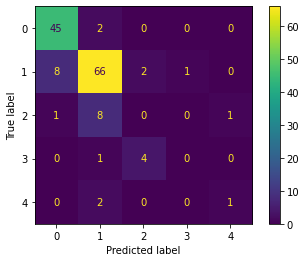

In [ ]:
cm = confusion_matrix(y_test, yhat, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score
print(precision_score(y_test, yhat, average=None,zero_division=1))
print(recall_score(y_test, yhat, average=None, zero_division=1))
print(f1_score(y_test, yhat, average=None))

[0.83333333 0.83544304 0.         0.         0.5       ]
[0.95744681 0.85714286 0.         0.         0.33333333]
[0.89108911 0.84615385 0.         0.         0.4       ]


KERNELIZED SUPPORT VECTOR

The SVM algorithm provides a large number of hyperparameters to tune.

**kernel**: control the manner in which the input variables will be projected. We consider the most popular kernel which are  linear, polynomial, and RBF.
kernels in [‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’]

**Penalty**: It takes range of value and it has effect on  the shape of the resulting regions for each class. 
C in [100, 10, 1.0, 0.1, 0.001]

In [ ]:
#Using the gridSearchCV
# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_t, y_t)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.823689 using {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.804440 (0.038851) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.801147 (0.037408) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.700892 (0.048727) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.804440 (0.038851) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.801147 (0.037408) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.752643 (0.043986) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.823689 (0.036368) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.815674 (0.035281) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.767693 (0.037266) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.750329 (0.044122) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.753146 (0.039488) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.734809 (0.033460) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.575453 (0.004408) with: {'C': 0.01, 'gamma': 'scale'

The best parameter  {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.2, random_state=0)
# Run classifier
classifier = OneVsRestClassifier(SVC(kernel='poly',C=1.0,gamma='scale', probability=True))
clf=classifier.fit(X_train, y_train)
print("model score: %.3f" % classifier.score(X_test, y_test))
yhat=classifier.predict(X_test)
print(yhat)
y_score = clf.decision_function(X_test)

model score: 0.838
[1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 2 1 0 0 1 0 1 1 1 2 1 0 1 0 0 1 1 1 0 1 1
 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1
 1 1 0 0 1 0 1 4 1 0 0 1 1 0 1 0 0 2 1 2 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0
 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 2 0 1 0 1 2 1 0 0 0 1 1 1 1 1]


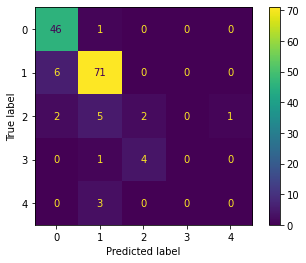

In [ ]:
cm = confusion_matrix(y_test, yhat, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score
print(precision_score(y_test, yhat, average=None,zero_division=1))
print(recall_score(y_test, yhat, average=None, zero_division=1))
print(f1_score(y_test, yhat, average=None))

[0.85185185 0.87654321 0.33333333 1.         0.        ]
[0.9787234  0.92207792 0.2        0.         0.        ]
[0.91089109 0.89873418 0.25       0.         0.        ]


Precision, Recall and F1 score

# Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
nn.fit(X_train, y_train)
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,solver='lbfgs')
print("model score: %.3f" % nn.score(X_test, y_test))
yhat=clf.predict(X_test)
print(yhat)

model score: 0.782
[1 2 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 2 1 0 1 0 0 1 4 1 0 1 1
 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 3 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1
 0 1 0 0 1 0 1 4 1 0 0 1 1 0 1 0 0 2 1 1 2 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0
 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 2 0 1 0 1 2 1 0 0 0 1 1 1 1 1]


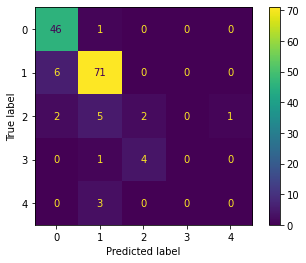

In [ ]:
cm = confusion_matrix(y_test, yhat, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

Precision, Recall and F1 score

In [ ]:
from sklearn.metrics import precision_score,recall_score
print(precision_score(y_test, yhat, average=None,zero_division=1))
print(recall_score(y_test, yhat, average=None, zero_division=1))
print(f1_score(y_test, yhat, average=None))

[0.85185185 0.87654321 0.33333333 1.         0.        ]
[0.9787234  0.92207792 0.2        0.         0.        ]
[0.91089109 0.89873418 0.25       0.         0.        ]


LR: 0.596794 (0.190500)
L-SVG: 0.515113 (0.137649)
K-SVM: 0.624933 (0.165041)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


NN: 0.540416 (0.092430)


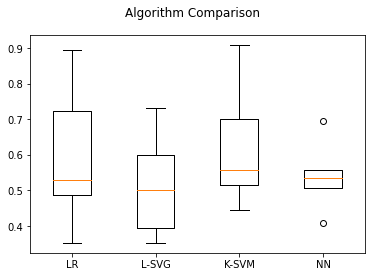

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# load dataset
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR',OneVsRestClassifier(LogisticRegression())))
models.append(('L-SVG',OneVsRestClassifier(SVC(kernel='poly',C=1.0,gamma='scale', probability=True))))
models.append(('K-SVM',OneVsRestClassifier(SVC(kernel='linear'))))
models.append(('NN', make_pipeline(StandardScaler(),MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1))))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5)
	cv_results = model_selection.cross_val_score(model, X_t, y_t, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()